# ABS Again
There seems to be a discrepancy in the current calculation by NEGF and the current calculated via the thermodynamic
relation $\frac{dE}{d\phi}$. I plan to investigate this in this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.special
import scipy.integrate

In [3]:
# create the Hamiltonian matrix

def calc_hamiltonian(params):
    '''
    Returns the Hamiltonian in the real space basis.
    params is a dict with the following information:
        N_z : number of points along z
        N_phi : number of points along azimuthal direction
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
    '''
    N_z = params['N_z']
    N_phi = params['N_phi']
    t_z = params['t_z']
    t_phi = params['t_phi']
    mu = params['mu']
    flux = params['flux']
    Delta = params['Delta']
    
    def calc_matrix_element(x,y):
        '''
        Returns the matrix element between two real space points x and y
        '''
        (z1,phi1) = x
        (z2,phi2) = y
        # onsite element
        if z1 == z2 and phi1 == phi2:
            #diag_ele = 2*t_z + np.abs(t_phi)*(2 + (2*np.pi*flux/N_phi)**2) - mu
            diag_ele = 2*t_z + np.abs(t_phi)*(2 + flux**2) - mu
            #if N_phi != 1:
            #    diag_ele = 2*t_z + np.abs(t_phi)*(2 + (2*np.pi*flux/N_phi)**2) - mu
            #else:
            #    # diagonal elemenet for N_phi = 1 does not make sense
            #    diag_ele = 2*t_z - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-diag_ele ]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[-t_z,0],[0,t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
    
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H_list = [calc_matrix_element(x,y) for x in basis for y in basis]
    N = N_phi*N_z
    H = np.array(H_list).reshape((N,N,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H = np.array([H[x,:,y,:].flatten() for x in range(H.shape[0]) for y in range(H.shape[2])])\
    .flatten().reshape(2*N,2*N)
    
    return H

# surface Green's funciton routines
# ordinary iteration schemes will be used

def calc_surface_g(E,alpha,beta,eta,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
   
    eta is used to calculated the Green's function
    eps controls the accuracy
    
    Returns the surface Green's function as a solution of the recursive relation 
    g = ((E + 1j*eta) - alpha - beta'*g*beta)^-1
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

def calc_sns_negf(E,params):
    '''
    Returns the G,A,Sigma matrices for SNS device. The chemical potential will be assumed to same everywhere and
    no bias is present across the device.
    params dict takes in these parameters:
        N_z : number of points along z in the normal region
        N_phi : number of points along azimuthal direction
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        Delta_1 : superconducting parameter 1
        Delta_2 : superconducting parameter 2
        eta : imaginary 0+ added for convergence
    '''
    N_z = params['N_z']
    N_phi = params['N_phi']
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta_1 = params['Delta_1']
    Delta_2 = params['Delta_2']
    mu = params['mu']
    eta = params['eta']
    flux = params['flux']
    kT = params['kT']
    
    # create alpha/beta hamiltonians for S regions
    # calc surface Green's function
   
    params_S1 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : Delta_1, "mu" : mu,"flux" : flux}
    H_S1 = calc_hamiltonian(params_S1)   
    surface_dof = 2*N_phi
    alpha_1 = H_S1[:surface_dof,:surface_dof]
    beta_1 = H_S1[:surface_dof,surface_dof:2*surface_dof]
    g_1 = calc_surface_g(E,alpha_1,beta_1,eta)
    
    params_S2 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : Delta_2, "mu" : mu,"flux" : flux}
    H_S2 = calc_hamiltonian(params_S2)   
    surface_dof = 2*N_phi
    alpha_2 = H_S2[:surface_dof,:surface_dof]
    beta_2 = H_S2[:surface_dof,surface_dof:2*surface_dof]
    g_2 = calc_surface_g(E,alpha_2,beta_2,eta)
    
    
    # create Hamiltonian for N region
    params_N = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : 0, "mu" : mu,"flux" : flux}
    H_mat = calc_hamiltonian(params_N)
    
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
    sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer
    
    sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
    gamma_1 = 1j*(sigma_1 - np.transpose(np.conj(sigma_1),(0,2,1)))
    
    sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    gamma_2 = 1j*(sigma_2 - np.transpose(np.conj(sigma_2),(0,2,1)))
    
    # NEGF matrices
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1))) 
    dos = np.real(np.trace(A,axis1=-2,axis2=-1))
    
    def fermi(E,kT):
        return scipy.special.expit(-E/kT)
    
    def generate_fermi_matrix(E,mu,kT):
        return np.array([[[fermi(ele - mu,kT),0],[0,fermi(ele + mu,kT)]] for ele in E])
        
    F1 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu-mu,kT))
    F2 = np.kron(np.eye(N_phi*N_z),generate_fermi_matrix(E,mu-mu,kT))
    sigma_in = np.matmul(gamma_1,F1) + np.matmul(gamma_2,F2)
    
    G_n = np.matmul(G,np.matmul(sigma_in,np.transpose(np.conj(G),(0,2,1))))
    dos = np.real(np.trace(G_n,axis1=-2,axis2=-1))
    
    #I_mat = 1j*(np.matmul(G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat],beta_layer) \
    #         - np.matmul(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer))
    I_mat = 1j*(np.matmul(H_mat,G_n) - np.matmul(G_n,H_mat))
    # current = electron current - hole current
    I = np.real(np.trace(I_mat[:,0:2*N_phi:2,0:2*N_phi:2]-I_mat[:,1:2*N_phi:2,1:2*N_phi:2],axis1=-1,axis2=-2))
    
    return G,A,dos,I

def integrate_current(E_vec,I_vec):
    return scipy.integrate.simps(I_vec,E_vec) 

def calc_I_phi(params,E_vec,phi_vec):
    I_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        G,A,dos,I = calc_sns_negf(E_vec,params)
        I_phi.append(integrate_current(E_vec,I))
    I_phi = np.array(I_phi)
    return I_phi

def calc_E_phi(params,E_vec,phi_vec):
    '''
    Returns the spectrum E(phi) for a single ABS
    '''
    E_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        G,A,dos,I = calc_sns_negf(E_vec,params)
        E_phi.append(E_vec[np.argmax(dos)])
    E_phi = np.array(E_phi)
    return E_phi

def calc_both_I_E_phi(params,E_vec,phi_vec):
    I_phi = []
    E_phi = []
    for phi in phi_vec:
        params['Delta_2'] = params['Delta_1']*np.exp(1j*phi)
        G,A,dos,I = calc_sns_negf(E_vec,params)
        I_phi.append(integrate_current(E_vec,I))
        E_phi.append(E_vec[np.argmax(dos)])
    E_phi = np.array(E_phi)
    I_phi = np.array(I_phi)
    
    I_grad_phi = 4*np.pi*np.gradient(E_phi,phi_vec)
    return I_phi,I_grad_phi 

# Current-Phase with Current Operator

In [32]:
params = {
    "N_z" : 40,
    "N_phi" : 1,
    "flux" : 0,
    "t_z" : 160e-3,
    "Delta_1" : 1e-3,
    "Delta_2" : 1e-3,
    "mu" : 60e-3,
    "kT" : 1e-6,
}
params["t_phi"] = 0e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

E_vec = np.linspace(-1e-3,1e-3,100)
#phi_vec = np.linspace(np.pi-0.5,np.pi+0.5,100)
phi_vec = np.linspace(-np.pi,np.pi,100)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

I_phi = calc_I_phi(params,E_vec,phi_vec)

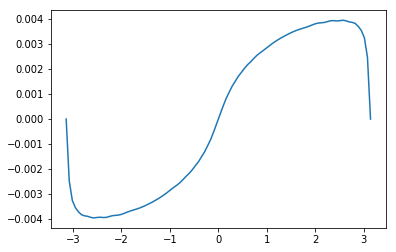

In [33]:
plt.plot(phi_vec,I_phi)

# E($\phi$) relation

In [34]:
E_vec = np.linspace(-1e-3,1e-3,1000)
params['eta'] = np.abs(E_vec[1] - E_vec[0])

E_phi = calc_E_phi(params,E_vec,phi_vec)

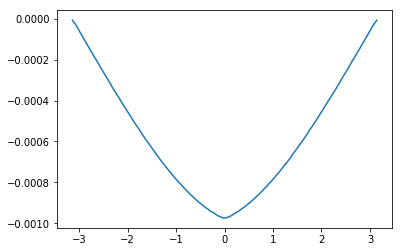

In [35]:
plt.plot(phi_vec,E_phi)

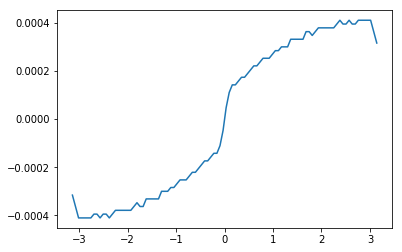

In [36]:
I_grad = np.gradient(E_phi,phi_vec)
plt.plot(phi_vec,I_grad)

# Comparison

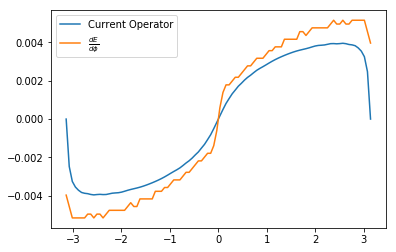

In [37]:
plt.plot(phi_vec,I_phi,label="Current Operator")
plt.plot(phi_vec,2*I_grad*2*np.pi,label=r"$\frac{dE}{d\phi}$")
#plt.plot(phi_vec,2*np.pi*1e-3*np.sin(phi_vec/2))
plt.legend()

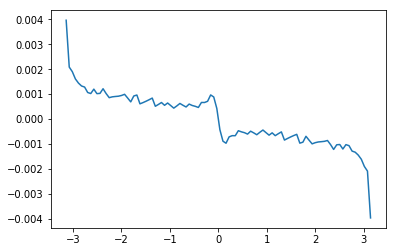

In [38]:
plt.plot(phi_vec,I_phi - 4*np.pi*I_grad)